# Jupyter Notebook to show the different steps of the code of the GAN

## Import the modules

In [17]:
import torch
from torch import nn
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from PIL import Image
import glob
import os
import torch.nn.functional as F
from datetime import datetime
import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision.utils import save_image, make_grid
import pickle
import subprocess

## Set the parameters / hyperparameters

In [23]:
device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
print(device)

# Definition of hyperparameters
num_epochs = 20
batch_size = 256


learning_rate_g = 0.0001
learning_rate_d = 0.00002
latent_vector_size = 40

# Other hyperparams
channel_input = 12
channel_output = 3



latent_dim = 50####REDUNDENT##### # Choose a value for the size of the latent space

content_path = ""
content_path = Path(content_path)

# Necessary Hyperparameters ####REDUNDENT##### --- >  redefined later on for convidence

# learning_rate = 1e-3####REDUNDENT#####
# latent_dim = 50####REDUNDENT##### # Choose a value for the size of the latent space

# Additional Hyperparameters ####REDUNDENT#####
beta = 1####REDUNDENT#####

def binary_threshold(input_tensor, threshold = 0.5):
    # Apply threshold
    return (input_tensor > threshold).float()

# (Optionally) Modify transformations on input
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(binary_threshold),
])

# (Optionally) Modify the network's output for visualizing your images
def denorm(x):
    return x


show = lambda img: plt.imshow(np.transpose(img.cpu().numpy(), (1,2,0)))

cuda


## Load the data

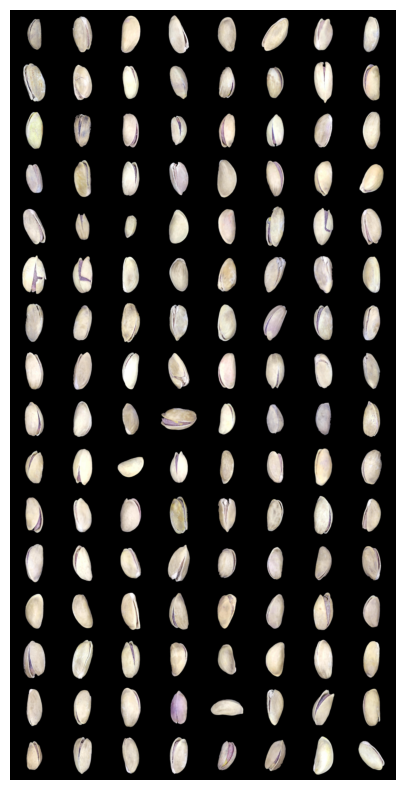

In [24]:
# Define a transform to resize the image and convert it to a tensor
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),          # Converts to [0, 1] and rearranges to (C, H, W)
])

# Define the directory and pattern to match the filenames
image_directory = 'Pistachio_Image_Dataset/Kirmizi_Pistachio'
pattern = os.path.join(image_directory, 'kirmizi *.jpg')

# Use glob to get all the file paths that match the pattern
image_paths = glob.glob(pattern)

# List to hold the image tensors
image_list = []

# Loop through image paths and process each image
for image_path in image_paths:
    # Open the image and convert to RGB
    image = Image.open(image_path).convert('RGB')
    
    # Apply the defined transform
    image_tensor = transform(image)  # Output tensor in range [0, 1]
    
    # Append the image tensor to the list
    image_list.append(image_tensor)

# Stack the list of image tensors into a single tensor of shape (N, C, H, W)
image_array = torch.stack(image_list)

# Create a TensorDataset with only image_array
dataset = TensorDataset(image_array)

# Define batch size
batch_size = 128

# Create a DataLoader to load the data in batches
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

loader_train = DataLoader(dataset, batch_size, shuffle=True)
loader_test = DataLoader(dataset, batch_size, shuffle=False)

# Get the first batch of images
first_batch = next(iter(loader_train))[0]  # Extracting images from TensorDataset

# Denormalization function (optional, if the images were normalized)
def denorm(tensor):
    return (tensor + 1.0) / 2.0

# Visualize the first batch of images using make_grid
grid = make_grid(first_batch, nrow=8, padding=2)

# Move the grid to the CPU and convert to a NumPy array
grid_np = grid.permute(1, 2, 0).numpy()

# Plot the grid of images
plt.figure(figsize=(10, 10))
plt.imshow(grid_np)
plt.axis('off')  # Hide the axes
plt.show()

## Define the model of the Generator and Discriminator

In [25]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Define the generator's layers with explicit parameter naming
        self.conv_transpose1 = nn.ConvTranspose2d(in_channels=latent_vector_size, out_channels=channel_input * 16, kernel_size=4, stride=1, padding=0, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(num_features=channel_input * 16)
        self.relu1 = nn.LeakyReLU(inplace=True)
        
        self.conv_transpose2 = nn.ConvTranspose2d(in_channels=channel_input * 16, out_channels=channel_input * 8, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(num_features=channel_input * 8)
        self.relu2 = nn.LeakyReLU(inplace=True)
        
        self.conv_transpose3 = nn.ConvTranspose2d(in_channels=channel_input * 8, out_channels=channel_input * 4, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(num_features=channel_input * 4)
        self.relu3 = nn.LeakyReLU(inplace=True)
        
        self.conv_transpose4 = nn.ConvTranspose2d(in_channels=channel_input * 4, out_channels= channel_output, kernel_size=4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, z):
        z = self.relu1(self.batch_norm1(self.conv_transpose1(z)))
        z = self.relu2(self.batch_norm2(self.conv_transpose2(z)))
        z = self.relu3(self.batch_norm3(self.conv_transpose3(z)))
        z = self.tanh(self.conv_transpose4(z))
        return z

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(channel_output, channel_input*4, 4, 2, 1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(channel_input*4)
        self.leaky_relu1 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv2 = nn.Conv2d(channel_input*4, channel_input*8, 4, 2, 1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(channel_input*8)
        self.leaky_relu2 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv3 = nn.Conv2d(channel_input*8, channel_input * 16, 4, 2, 1, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(channel_input*16)
        self.leaky_relu3 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv4 = nn.Conv2d(channel_input*16, channel_input * 32, 4, 2, 1, bias=False)
        self.batch_norm4 = nn.BatchNorm2d(channel_input*32)
        self.leaky_relu4 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv5 = nn.Conv2d(channel_input*32, channel_input * 64, 2, 1, 1, bias=False)
        self.batch_norm5 = nn.BatchNorm2d(channel_input*64)
        self.leaky_relu5 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv6 = nn.Conv2d(channel_input*64, 1, 3, 1, 0, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu1(self.batch_norm1(self.conv1(x)))
        x = self.leaky_relu2(self.batch_norm2(self.conv2(x)))
        x = self.leaky_relu3(self.batch_norm3(self.conv3(x)))
        x = self.leaky_relu4(self.batch_norm4(self.conv4(x)))
        x = self.leaky_relu5(self.batch_norm5(self.conv5(x)))
        x = self.sigmoid(self.conv6(x))
        return x

## Define custom weights and initialise model

In [26]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))


Total number of parameters in Generator is: 494496
Generator(
  (conv_transpose1): ConvTranspose2d(40, 192, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batch_norm1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01, inplace=True)
  (conv_transpose2): ConvTranspose2d(192, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01, inplace=True)
  (conv_transpose3): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01, inplace=True)
  (conv_transpose4): ConvTranspose2d(48, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tanh): Tanh()
)


Total number of parameters in Discrimina

## Define a loss and choose optimisers

In [27]:
# You can modify the arguments of this function if needed
def loss_function(out, real_or_fake):
    if real_or_fake == 'real':
        loss = F.binary_cross_entropy(out, torch.ones(out.size()).to(device))
    elif real_or_fake == 'fake':
        loss = F.binary_cross_entropy(out, torch.zeros(out.size()).to(device))
    else:
        raise ValueError('real_or_fake must be either "real" or "fake"')
    return loss

beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate_d, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate_g, betas=(beta1, 0.999))

fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

## Define the hyperparameters to be tuned

In [28]:
num_epochs =10
learning_rate_g = 0.00001
learning_rate_d = 0.00002
latent_vector_size = 40

# Other hyperparams
channel_input = 32
channel_output = 3

## Training loop

In [29]:


# Set up a relative content path (outputs stored in the current working directory)
content_path = Path.cwd()  # This points to the directory where the repo is cloned
os.makedirs(content_path / 'CW_GAN', exist_ok=True)  # Create 'CW_GAN' directory if it doesn't exist

# List to store losses
train_losses_G = []  # List to store generator losses
train_losses_D = []  # List to store discriminator losses

num_epochs = 100
initial_lr_g = 0.000001
initial_lr_d = 0.000001
max_lr_g = 0.001
max_lr_d = 0.001

# Function to push images to GitHub
def push_to_github(commit_message):
    try:
        # Add all changes (images) to the GitHub repo
        subprocess.run(["git", "add", "."], check=True, cwd=str(content_path))
        # Commit the changes with a message
        subprocess.run(["git", "commit", "-m", commit_message], check=True, cwd=str(content_path))
        # Push the changes to the remote repository
        subprocess.run(["git", "push"], check=True, cwd=str(content_path))
        print(f"Successfully pushed images to GitHub with message: {commit_message}")
    except subprocess.CalledProcessError as e:
        print(f"Failed to push images to GitHub: {e}")

# Loop for learning_rate_d adjustments
lr_d = initial_lr_d
while lr_d <= max_lr_d:
    learning_rate_d = lr_d
    
    # Reset learning_rate_g at the start of each learning_rate_d loop
    lr_g = initial_lr_g
    
    # Loop for learning_rate_g adjustments
    while lr_g <= max_lr_g:
        learning_rate_g = lr_g

        # Define your optimizers with the updated learning rates
        optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate_d)
        optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate_g)

        # Training loop for the current combination of learning_rate_d and learning_rate_g
        for epoch in range(num_epochs):
            # Progress bar with tqdm to monitor each batch
            with tqdm.tqdm(loader_train, unit="batch") as tepoch: 
                train_loss_D = 0
                train_loss_G = 0
                for i, data in enumerate(tepoch):
                    # Initialize loss variables for this batch

                    model_D.zero_grad()  
                    real_cpu = data[0].to(device)  
                    b_size = real_cpu.size(0)  

                    output = model_D(real_cpu).view(-1)
                    errD_real = loss_function(output, 'real')  # Loss for real images
                    errD_real.backward()  
                    D_x = output.mean().item() 

                    noise = torch.randn(b_size, latent_vector_size, 1, 1, device=device)  # Generate random noise
                    fake = model_G(noise)  
                    output = model_D(fake.detach()).view(-1)  # Detach to avoid training G on these labels
                    errD_fake = loss_function(output, 'fake')  
                    errD_fake.backward()  
                    D_G_z1 = output.mean().item() 
                    errD = errD_real + errD_fake  
                    train_loss_D += errD.item() 
                    optimizerD.step()

                    model_G.zero_grad()  
                    output = model_D(fake).view(-1) 
                    errG = loss_function(output, 'real')
                    train_loss_G += errG.item()
                    errG.backward()
                    D_G_z2 = output.mean().item()
                    optimizerG.step()

                    # Logging and updating the tqdm progress bar
                    if i % 50 == 0:
                        tepoch.set_description(f"Epoch {epoch}")
                        tepoch.set_postfix(D_G_z=f"{D_G_z1:.3f}/{D_G_z2:.3f}", D_x=D_x,
                                           Loss_D=errD.item(), Loss_G=errG.item())

            # Save real images once at the beginning of training
            if epoch == 0:
                save_image(denorm(real_cpu.cpu()).float(), content_path/'CW_GAN/real_samples.png')

            # Generate and save fake images periodically
            with torch.no_grad():
                fake = model_G(fixed_noise)  # Generate fake images
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')  # Get current time for file naming
                filename = str(content_path / 'CW_GAN' / f'fake_samples_epoch_{epoch:03d}_lrG_{learning_rate_g:.6f}_lrD_{learning_rate_d:.6f}_{timestamp}.png')
                save_image(denorm(fake.cpu()).float(), filename)  # Save generated images with timestamp and learning rates

            # Update training loss lists
            train_losses_D.append(train_loss_D / len(loader_train))  # Average discriminator loss for this epoch
            train_losses_G.append(train_loss_G / len(loader_train))  # Average generator loss for this epoch

        # Update learning rate for generator by multiplying by 5
        lr_g *= 20

    # Push all images generated in the current learning_rate_d loop to GitHub
    commit_message = f"Push fake images for learning_rate_d={learning_rate_d:.6f} and learning_rate_g={learning_rate_g:.6f}"
    push_to_github(commit_message)

    # Update learning rate for discriminator by multiplying by 5
    lr_d *= 20


Epoch 69:  30%|███       | 3/10 [00:00<00:00, 12.76batch/s, D_G_z=0.033/0.033, D_x=0.926, Loss_D=0.115, Loss_G=3.74]


KeyboardInterrupt: 

In [17]:
# # Set up a relative content path (outputs stored in the current working directory)
# content_path = Path.cwd()  # This points to the directory where the repo is cloned
# os.makedirs(content_path / 'CW_GAN', exist_ok=True)  # Create 'CW_GAN' directory if it doesn't exist

# # List to store losses
# train_losses_G = []  # List to store generator losses
# train_losses_D = []  # List to store discriminator losses

# num_epochs =10
# learning_rate_g = 0.000001
# learning_rate_d = 0.000001

# # Training loop
# for epoch in range(num_epochs):
#     # Progress bar with tqdm to monitor each batch
#     with tqdm.tqdm(loader_train, unit="batch") as tepoch: 
#         train_loss_D = 0
#         train_loss_G = 0
#         for i, data in enumerate(tepoch):
#             # Initialize loss variables for this batch

            

#             model_D.zero_grad()  
#             real_cpu = data[0].to(device)  
#             b_size = real_cpu.size(0)  


#             output = model_D(real_cpu).view(-1)
#             errD_real = loss_function(output, 'real')  # Loss for real images
#             errD_real.backward()  
#             D_x = output.mean().item() 


#             noise = torch.randn(b_size, latent_vector_size, 1, 1, device=device)  # Generate random noise
#             fake = model_G(noise)  
#             output = model_D(fake.detach()).view(-1)  # Detach to avoid training G on these labels
#             errD_fake = loss_function(output, 'fake')  
#             errD_fake.backward()  
#             D_G_z1 = output.mean().item() 
#             errD = errD_real + errD_fake  
#             train_loss_D += errD.item() 
#             optimizerD.step()

#             model_G.zero_grad()  
#             output = model_D(fake).view(-1) 
#             errG = loss_function(output, 'real')
#             train_loss_G += errG.item()
#             errG.backward()
#             D_G_z2 = output.mean().item()
#             optimizerG.step()

#             # Logging and updating the tqdm progress bar
#             if i % 50 == 0:
#                 tepoch.set_description(f"Epoch {epoch}")
#                 tepoch.set_postfix(D_G_z=f"{D_G_z1:.3f}/{D_G_z2:.3f}", D_x=D_x,
#                                    Loss_D=errD.item(), Loss_G=errG.item())

#     # Save real images once at the beginning of training
#     if epoch == 0:
#         save_image(denorm(real_cpu.cpu()).float(), content_path/'CW_GAN/real_samples.png')
    
#     # Generate and save fake images periodically
#     with torch.no_grad():
#         fake = model_G(fixed_noise)  # Generate fake images
#         timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')  # Get current time for file naming
#         filename = str(content_path / 'CW_GAN' / f'fake_samples_epoch_{epoch:03d}_{timestamp}.png')
#         save_image(denorm(fake.cpu()).float(), filename)  # Save generated images with timestamp

    

#     # Update training loss lists
#     train_losses_D.append(train_loss_D / len(loader_train))  # Average discriminator loss for this epoch
#     train_losses_G.append(train_loss_G / len(loader_train))  # Average generator loss for this epoch

#     # torch.jit.save(torch.jit.trace(model_D, (fake)), content_path/'CW_GAN/GAN_D_model.pth')
#     # torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), content_path/'CW_GAN/GAN_G_model.pth')
#     loss_data = {
#         'train_loss_D': train_losses_D,
#         'train_loss_G': train_losses_G
#     }
#     filename = content_path / 'CW_GAN' / 'loss_data.pkl'
#     with open(filename, 'wb') as file:
#         pickle.dump(loss_data, file)

Epoch 9: 100%|██████████| 10/10 [00:01<00:00,  5.41batch/s, D_G_z=0.001/0.000, D_x=0.999, Loss_D=0.00186, Loss_G=8.07]


In [ ]:
torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), content_path/'CW_GAN/GAN_G_model.pth')
torch.jit.save(torch.jit.trace(model_D, (fake)), content_path/'CW_GAN/GAN_D_model.pth')

In [ ]:
fake_image = Image.open('CW_GAN/fake_samples_epoch_009_20240926_173455.png')
fake_image.show()

## Results: Generator samples

In [ ]:
mG = torch.jit.load('/notebooks/CW_GAN/GAN_G_model.pth')
model_G.load_state_dict(mG.state_dict())

mD = torch.jit.load('/notebooks/CW_GAN/GAN_D_model.pth')
model_D.load_state_dict(mD.state_dict())


input_noise = torch.randn(100, latent_vector_size, 1, 1, device=device)
with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:100], nrow=10, padding=2, normalize=False, 
                        value_range=None, scale_each=False, pad_value=0)
    plt.figure(figsize=(15,15))
    save_image(generated, content_path/'CW_GAN/Teaching_final.png')
    show(generated) # note these are now class conditional images columns rep classes 1-10

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:64, :, :, :]
# visualize the original images of the last batch of the test set for comparison
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
show(img)

## Loss curves

In [ ]:
# ANSWER FOR PART 2.2 IN THIS CELL*
# load the loss data 
import math 
filename = content_path / 'CW_GAN' / 'loss_data.pkl'
with open(filename, 'rb') as file:
    loss_data = pickle.load(file)

# unpack loss_data into variables
    
train_loss_data_D = loss_data['train_loss_D'] 
train_loss_data_G = loss_data['train_loss_G']

# plot the loss data
plt.figure(figsize=(10, 5))
plt.plot(train_loss_data_D, label='Discriminator')
plt.plot(train_loss_data_G, label='Generator')
plt.title('GAN Training Loss')

# plot a red dashed line at x = 150
plt.axvline(x=150, color='r', linestyle='--')


plt.xlabel('Epochs')
plt.ylabel('Loss')  

# add a legend of the red line being the termination point 
plt.legend(['Discriminator', 'Generator', 'Termination Point'])
